# use class to encapsulate scraping functions

2021/01/03

In [ ]:
from STEP0_paths_open_save import open_files, save_files
from STEP1_scraping_cleaning_merge import scrape, app_detail_dicts
from STEP2_pre_processing import pre_processing
from STEP3_NLP_pipeline import nlp_pipeline

# 1. Scraping

In [1]:
%run -i 'STEP0_paths_open_save.py'
%run -i 'STEP1_scraping_cleaning_merge.py'
from datetime import datetime
today = datetime.today()
yearmonth = today.strftime("%Y%m")
print(yearmonth)

initial_panels = ['201812', '201907', '201908', '201912', '202001', '202002']
current_panel = yearmonth

for i in initial_panels:
    o = open_files(initial_panel=i)
    DF = o.open_df_to_id_for_scraping()
    new_class_obj = scrape(data_before_202009=DF)
    print('start scraping apps with initial panel', i)
    app_details = new_class_obj.scraping_apps_according_to_id()
    print('Finished scraping app details with initial panel', i)
    s = save_files(initial_panel=i,
                   current_panel=current_panel,
                   app_details_dict=app_details)
    s.save_scraped_app_details()
    print('Saved scarped app details with initial panel', i)

scraping...: 100%|██████████| 8042/8042 [1:02:59<00:00,  2.13it/s] 


202103
start scraping apps with initial panel 201812
The number of IDs are: 5977
Finished scraping app details with initial panel 201812
Saved scarped app details with initial panel 201812
start scraping apps with initial panel 201907
The number of IDs are: 13144
Finished scraping app details with initial panel 201907
Saved scarped app details with initial panel 201907
start scraping apps with initial panel 201908
The number of IDs are: 13015
Finished scraping app details with initial panel 201908
Saved scarped app details with initial panel 201908
start scraping apps with initial panel 201912
The number of IDs are: 8468
Finished scraping app details with initial panel 201912
Saved scarped app details with initial panel 201912
start scraping apps with initial panel 202001
The number of IDs are: 8359
Finished scraping app details with initial panel 202001
Saved scarped app details with initial panel 202001
start scraping apps with initial panel 202002
The number of IDs are: 8042
Finishe

# 3. Convert

In [3]:
%run -i 'STEP0_paths_open_save.py'
%run -i 'STEP1_scraping_cleaning_merge.py'
# key represents initial panel, value represents panels (including the initial) tracking the initial panel
panels_track = {
'201812':['201812', '201912', '202001', '202003', '202004', '202009', '202010',
          '202011', '202012', '202101', '202102', '202103'],
'201907':['201907', '201908', '201909', '201912', '202001', '202003', '202004',
          '202009', '202010', '202011', '202012', '202101', '202102', '202103'],
'201908':['201908', '201912', '202001', '202003', '202004', '202009', '202010',
          '202011', '202012', '202101', '202102', '202103'],
'201912':['201912', '202001', '202003', '202004', '202009', '202010', '202011',
          '202012', '202101', '202102', '202103'],
'202001':['202001', '202003', '202004', '202009', '202010', '202011', '202012',
          '202101', '202102', '202103'],
'202002':['202002', '202004', '202009', '202010', '202011', '202012', '202101',
          '202102', '202103']}

for initial_panel, all_panels in panels_track.items():
    o = open_files(initial_panel=initial_panel,
                   all_panels=all_panels)
    app_details = o.open_initial_panel_with_its_tracking_panels()
    A = app_detail_dicts(d=app_details, all_panels=all_panels)
    merged_df = A.merge_panels_into_single_df()
    save = save_files(initial_panel=initial_panel, df=merged_df)
    save.save_panel_df(name='MERGED')
    print('panel data', initial_panel, 'has shape:')
    print(merged_df.shape)

panel data 201812 has shape:
(4278, 319)
panel data 201907 has shape:
(10576, 371)
panel data 201908 has shape:
(10537, 319)
panel data 201912 has shape:
(7058, 293)
panel data 202001 has shape:
(7027, 267)
panel data 202002 has shape:
(6860, 241)


# 4. Convert to Developer Index and Geocode Addresses

In [ ]:
from tqdm.auto import tqdm
tqdm.pandas()
%run -i 'STEP0_paths_open_save.py'
%run -i 'STEP1_scraping_cleaning_merge.py'
%run -i 'STEP2_pre_processing.py'

panels_track = {
'201812':['201812', '201912', '202001', '202003', '202004', '202009', '202010',
          '202011', '202012', '202101', '202102'],
'201907':['201907', '201908', '201909', '201912', '202001', '202003', '202004',
          '202009', '202010', '202011', '202012', '202101', '202102'],
'201908':['201908', '201912', '202001', '202003', '202004', '202009', '202010',
          '202011', '202012', '202101', '202102'],
'201912':['201912', '202001', '202003', '202004', '202009', '202010', '202011',
          '202012', '202101', '202102'],
'202001':['202001', '202003', '202004', '202009', '202010', '202011', '202012',
          '202101', '202102'],
'202002':['202002', '202004', '202009', '202010', '202011', '202012', '202101',
          '202102']}
consec_panels = ['202009', '202010', '202011', '202012', '202101', '202102']
# ***************************************************************************************
for initial_panel, all_panels in panels_track.items():
    o = open_files(initial_panel=initial_panel)
    merged_df = o.open_panel_df(name='MERGED')
    new_class_obj = pre_processing(
                     df=merged_df,
                     df_index = 'appid',
                     initial_panel=initial_panel,
                     all_panels=all_panels,
                     consec_panels=consec_panels)
    DF = new_class_obj.lat_and_long_columns(
                    multiindex=False,
                    consecutive=False)
    s = save_files(df=DF, initial_panel=initial_panel)
    s.save_panel_df(name='dev_index_geocoded')
    print('finished converting', initial_panel, 'dataset')
    print()
    print()

# 5. Impute Missing
Since I will need interval data, so I will only impute from consecutive_panels

In [1]:
%run -i 'STEP0_paths_open_save.py'
%run -i 'STEP1_scraping_cleaning_merge.py'
%run -i 'STEP2_pre_processing.py'

all_init_panels = ['201812', '201907', '201908', '201912', '202001', '202002']
panels_track = {
'201812':['201812', '201912', '202001', '202003', '202004', '202009', '202010',
          '202011', '202012', '202101', '202102', '202103'],
'201907':['201907', '201908', '201909', '201912', '202001', '202003', '202004',
          '202009', '202010', '202011', '202012', '202101', '202102', '202103'],
'201908':['201908', '201912', '202001', '202003', '202004', '202009', '202010',
          '202011', '202012', '202101', '202102', '202103'],
'201912':['201912', '202001', '202003', '202004', '202009', '202010', '202011',
          '202012', '202101', '202102', '202103'],
'202001':['202001', '202003', '202004', '202009', '202010', '202011', '202012',
          '202101', '202102', '202103'],
'202002':['202002', '202004', '202009', '202010', '202011', '202012', '202101',
          '202102', '202103']}
consec_panels = ['202009', '202010', '202011', '202012', '202101', '202102',
                 '202103']

vars_to_count_missing = ['minInstalls', 'score', 'reviews',
                         'ratings', 'price', 'released',
                         'updated', 'size', 'free',
                          'containsAds', 'offersIAP', 'contentRating',
                          'genreId']
imputation_block = {'minInstalls':[1, 'previous'],
                       'score':[4, 'mean'],
                       'reviews':[4, 'mean'],
                       'ratings':[4, 'mean'],
                       'price':[4, 'mean'],
                       'size':[8, 'mode'],
                       'released':[5, 'mode'],
                       'contentRating':[5, 'mode'],
                       'genreId':[5,'mode'],
                       'updated':[1, 'previous'],
                       'free':[5, 'mode if none-missing are all the same'],
                       'containsAds':[5, 'mode if none-missing are all the same'],
                       'offersIAP':[5, 'mode if none-missing are all the same']}
# updated value has to strictly follow the previous panel's
# ***************************************************************************************
for initial_panel, all_panels in panels_track.items():
    o = open_files(initial_panel=initial_panel)
    merged_df = o.open_panel_df(name='MERGED')
    new_class_obj = pre_processing(
                 df=merged_df,
                 df_index = 'appid',
                 initial_panel=initial_panel,
                 all_panels=all_panels,
                 consec_panels=consec_panels)
    # --------------- check missing before imputing --------------------------------------
    missingdf = new_class_obj.count_missing(
        var_list=vars_to_count_missing,
        consecutive=True)
    s = save_files(df=missingdf, initial_panel=initial_panel)
    s.save_df_to_csv(name='missing_count_before_imputation')
    print(missingdf)
    # --------------- IMPUTING ----------------------------------------------------------
    cols_to_impute = []
    for c, specs in imputation_block.items():
        imputed_cols = new_class_obj.impute_missing_using_adj_panels(
            var=c,
            consecutive=True,
            adj_panels=specs[0],
            method=specs[1])
        cols_to_impute.append(imputed_cols)
    IMPUTED_DF = new_class_obj.replace_cols_list(list_new_cols=cols_to_impute)
    # ----------------- check missing after imputing ----------------------------------
    missingdf = IMPUTED_DF.count_missing(
        var_list=vars_to_count_missing,
        consecutive=True)
    s = save_files(df=missingdf, initial_panel=initial_panel)
    s.save_df_to_csv(name='missing_count_after_imputation')
    print(missingdf)
    # ------------------ save ---------------------------------------------------------
    s = save_files(df=IMPUTED_DF.df, initial_panel=initial_panel)
    s.save_panel_df(name='imputed_missing')
    print('finished imputing missing for', initial_panel, 'dataset')
    print()
    print()

                      count missing
minInstalls_202009    16           
minInstalls_202010    62           
minInstalls_202011    112          
minInstalls_202012    190          
minInstalls_202101    225          
minInstalls_202102    266          
minInstalls_202103    313          
score_202009          26           
score_202010          72           
score_202011          122          
score_202012          200          
score_202101          235          
score_202102          276          
score_202103          323          
reviews_202009        26           
reviews_202010        72           
reviews_202011        122          
reviews_202012        200          
reviews_202101        235          
reviews_202102        276          
reviews_202103        323          
ratings_202009        405          
ratings_202010        437          
ratings_202011        473          
ratings_202012        542          
ratings_202101        569          
ratings_202102        590   

# 6. Delete Missing
Ignore appids that changed developer over time, because we have not imputed developers,
and so we are not deleting the appids that changed developer over time.

I will not use size variable for now because size has to many missing, and I have not come up
with a good way to impute them.

Not going to use updated in my regression, not sure how to impute them the best.

In [1]:
%run -i 'STEP0_paths_open_save.py'
%run -i 'STEP1_scraping_cleaning_merge.py'
%run -i 'STEP2_pre_processing.py'

all_init_panels = ['201812', '201907', '201908', '201912', '202001', '202002']
panels_track = {
'201812':['201812', '201912', '202001', '202003', '202004', '202009', '202010',
          '202011', '202012', '202101', '202102', '202103'],
'201907':['201907', '201908', '201909', '201912', '202001', '202003', '202004',
          '202009', '202010', '202011', '202012', '202101', '202102', '202103'],
'201908':['201908', '201912', '202001', '202003', '202004', '202009', '202010',
          '202011', '202012', '202101', '202102', '202103'],
'201912':['201912', '202001', '202003', '202004', '202009', '202010', '202011',
          '202012', '202101', '202102', '202103'],
'202001':['202001', '202003', '202004', '202009', '202010', '202011', '202012',
          '202101', '202102', '202103'],
'202002':['202002', '202004', '202009', '202010', '202011', '202012', '202101',
          '202102', '202103']}
consec_panels = ['202009', '202010', '202011', '202012', '202101', '202102',
                 '202103']
vars_list = ['minInstalls', 'score', 'reviews',
             'ratings', 'price','released', 'free',
             'containsAds', 'offersIAP', 'contentRating', 'genreId']
# ***************************************************************************************
for initial_panel, all_panels in panels_track.items():
    o = open_files(initial_panel=initial_panel)
    df = o.open_panel_df(name='imputed_missing')
    new_class_obj = pre_processing(
                 df=df,
                 df_index = 'appid',
                 initial_panel=initial_panel,
                 all_panels=all_panels,
                 consec_panels=consec_panels)
    appids_to_remove = []
    for var in vars_list:
        appid_list, null_df = new_class_obj.check_appids_with_at_least_one_missing(
        var=var,
        consecutive=True)
        appids_to_remove.extend(appid_list)
    print('total', len(appids_to_remove), 'to remove')
    appids_to_remove = list(set(appids_to_remove))
    print('total unique', len(appids_to_remove), 'to remove')
    print('before remove rows', initial_panel, 'has shape', new_class_obj.df.shape)
    new_df = new_class_obj.drop_rows(list_of_row_labels=appids_to_remove)
    print('after remove rows', initial_panel, 'has shape', new_df.df.shape)
    # ----------------- check missing after deletion ----------------------------------
    missingdf = new_df.count_missing(var_list=vars_list,
                                     consecutive=True)
    s = save_files(df=missingdf, initial_panel=initial_panel)
    s.save_df_to_csv(name='missing_count_after_imputation_and_deletion')
    print(missingdf)
    # ------------------------------ save ---------------------------------------------
    s = save_files(df=new_df.df, initial_panel=initial_panel)
    s.save_panel_df(name='imputed_and_deleted_missing')
    print('finished imputing and deleting missing for', initial_panel, 'dataset')
    print()
    print()

total 1429 to remove
total unique 645 to remove
before remove rows 201812 has shape (4278, 319)
after remove rows 201812 has shape (3633, 319)
                      count missing
minInstalls_202009    0            
minInstalls_202010    0            
minInstalls_202011    0            
minInstalls_202012    0            
minInstalls_202101    0            
minInstalls_202102    0            
minInstalls_202103    0            
score_202009          0            
score_202010          0            
score_202011          0            
score_202012          0            
score_202101          0            
score_202102          0            
score_202103          0            
reviews_202009        0            
reviews_202010        0            
reviews_202011        0            
reviews_202012        0            
reviews_202101        0            
reviews_202102        0            
reviews_202103        0            
ratings_202009        0            
ratings_202010        0      

# 6. NLP Pipeline

In [13]:
%run -i 'STEP0_paths_open_save.py'
%run -i 'STEP3_NLP_pipeline.py'

all_init_panels = ['201812', '201907', '201908', '201912', '202001', '202002',
                   '202103']
panels_track = {
'201812':['201812', '201912', '202001', '202003', '202004', '202009', '202010',
          '202011', '202012', '202101', '202102', '202103'],
'201907':['201907', '201908', '201909', '201912', '202001', '202003', '202004',
          '202009', '202010', '202011', '202012', '202101', '202102', '202103'],
'201908':['201908', '201912', '202001', '202003', '202004', '202009', '202010',
          '202011', '202012', '202101', '202102', '202103'],
'201912':['201912', '202001', '202003', '202004', '202009', '202010', '202011',
          '202012', '202101', '202102', '202103'],
'202001':['202001', '202003', '202004', '202009', '202010', '202011', '202012',
          '202101', '202102', '202103'],
'202002':['202002', '202004', '202009', '202010', '202011', '202012', '202101',
          '202102', '202103']}

before removing rows with all none in text cols, we have 3633
after removing rows with all none in text cols, we have 3633
successfully imputed missing text columns for TEXT COLUMN (combined from all panels) of the dataset 201812
assuming all text columns are time-invariant
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
Number of components = 4 and explained variance = 0.03525481952165284
Number of components = 10 and explained variance = 0.0732203538590937
Number of components = 15 and explained variance = 0.09593537236476317
Number of components = 20 and explained variance = 0.11598356732826225
Number of components = 50 and explained variance = 0.20489204012619072
Number of components = 100 and explained variance = 0.3028579260563196
Number of components = 150 and explained variance = 0.3762818144049852
Number of components = 200 and explained variance = 0.43768171274461826
Number of components = 500 and explained var

 59%|█████▉    | 13/22 [00:06<00:04,  2.14it/s]


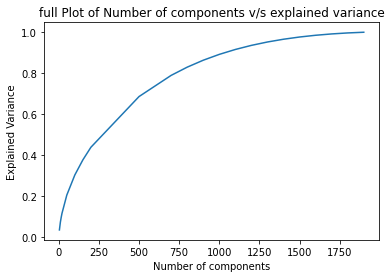

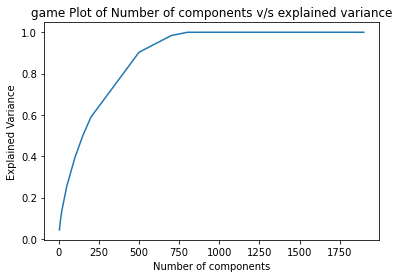

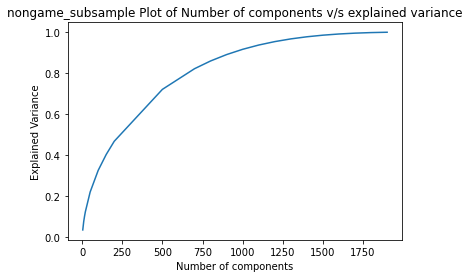

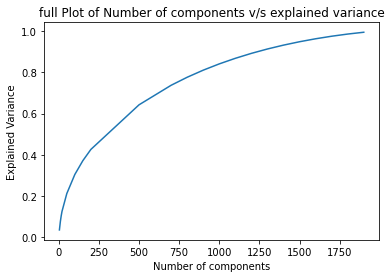

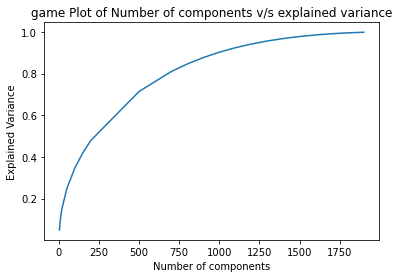

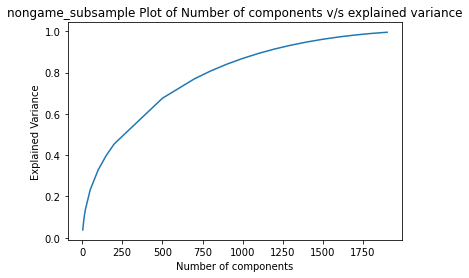

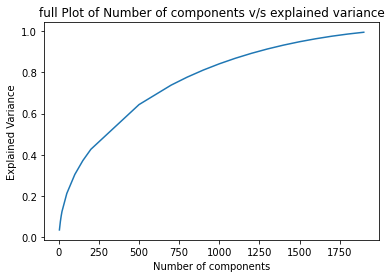

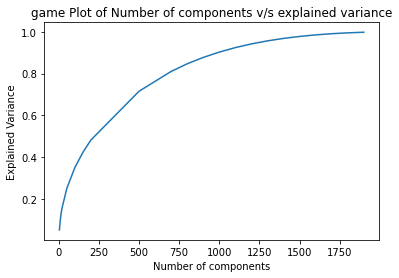

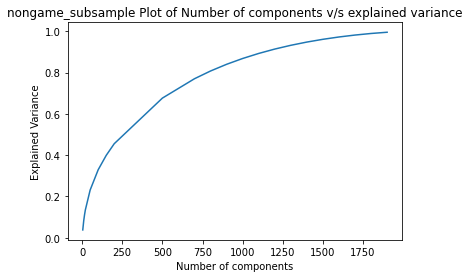

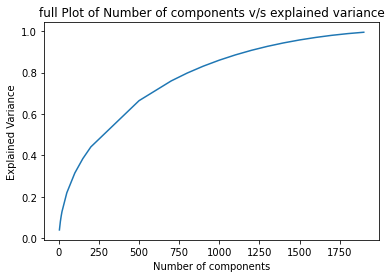

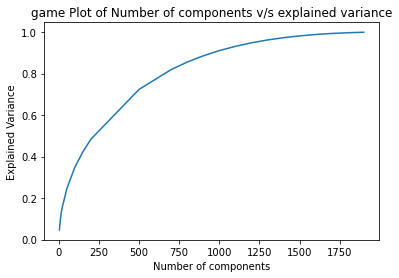

KeyboardInterrupt: 

In [14]:
for initial_panel, all_panels in panels_track.items():
    o = open_files(initial_panel=initial_panel)
    DF = o.open_panel_df(name='imputed_and_deleted_missing')
    new_class_obj = nlp_pipeline(
                      df=DF,
                      tcn='description',
                      initial_panel=initial_panel,
                      all_panels=all_panels)

    d1 = new_class_obj.find_appids_to_remove_before_imputing(
            ).impute_text_cols(
            ).prepare_text_col(
            ).divide_into_subsamples(
            ).generate_save_input_text_col(
            ).tf_idf_transformation(
            ).find_optimal_svd_component_plot(
            )

In [ ]:
    # even though I decided 400 clusters, I found cluster label 162 is missing, so there are 399 clusters ends up
    df_labels = new_class_obj.kmeans_cluster(
        n_clusters=400,
        init='k-means++',
        random_state=50,
        n_comp=1000,
        consecutive=True,
        combine_panels=True)
    print('finished predicting text cluster labels for', initial_panel, 'dataset')
    print()
    print()

In [5]:
for initial_panel, all_panels in panels_track.items():
    o = open_files(initial_panel=initial_panel)
    DF = o.open_panel_df(name='MERGED')
    df_labels = o.open_panel_df(name='predicted_kmeans_labels_combined_panels')
    new_class_obj = nlp_pipeline(
                  df=DF,
                  df_labels=df_labels,
                  text_col_name='description',
                  initial_panel=initial_panel,
                  consec_panels=consec_panels)
    new_class_obj.find_appids_to_remove_before_imputing(
        consecutive=True).impute_text_cols(
        consecutive=True, combine_panels=True)
    niche_app_df = new_class_obj.label_broad_niche_apps(
        label_name='combined_panels_kmeans_labels',
        top_n=3,
        combine_panels=True)
    # ------------------------------ save ---------------------------------------------
    s = save_files(df=niche_app_df, initial_panel=initial_panel)
    s.save_panel_df(name='niche_labels_combined_panels')
    print('finished assigning broad and niche labels for', initial_panel, 'dataset')
    print()
    print()

before removing rows with all none in text cols, we have 4278
after removing rows with all none in text cols, we have 4270
successfully imputed missing text columns for COMBINED TEXT COLUMN of the dataset 201812
assuming all text columns are time-invariant
niche_app
0    1434
1    2836
Name: count, dtype: int64
finished assigning broad and niche labels for 201812 dataset
before removing rows with all none in text cols, we have 10576
after removing rows with all none in text cols, we have 10548
successfully imputed missing text columns for COMBINED TEXT COLUMN of the dataset 201907
assuming all text columns are time-invariant
niche_app
0    1720
1    8828
Name: count, dtype: int64
finished assigning broad and niche labels for 201907 dataset
before removing rows with all none in text cols, we have 10537
after removing rows with all none in text cols, we have 10515
successfully imputed missing text columns for COMBINED TEXT COLUMN of the dataset 201908
assuming all text columns are time-i

In [ ]:
df4 = new_class_obj.eyeball_app_with_label(
    label_name='combined_panels_kmeans_labels',
    top_n=3,
    niche=True,
    combine_panels=True)

df5 = new_class_obj.eyeball_app_with_label(
    label_name='combined_panels_kmeans_labels',
    top_n=3,
    niche=False,
    combine_panels=True)

# 7. Combine Dataframes

In [ ]:
%run -i 'STEP0_paths_open_save.py'
%run -i 'STEP3_NLP_pipeline.py'
%run -i 'STEP4_Regression.py'

all_init_panels = ['201812', '201907', '201908', '201912', '202001', '202002',
                   '202103']
panels_track = {
'201812':['201812', '201912', '202001', '202003', '202004', '202009', '202010',
          '202011', '202012', '202101', '202102', '202103'],
'201907':['201907', '201908', '201909', '201912', '202001', '202003', '202004',
          '202009', '202010', '202011', '202012', '202101', '202102', '202103'],
'201908':['201908', '201912', '202001', '202003', '202004', '202009', '202010',
          '202011', '202012', '202101', '202102', '202103'],
'201912':['201912', '202001', '202003', '202004', '202009', '202010', '202011',
          '202012', '202101', '202102', '202103'],
'202001':['202001', '202003', '202004', '202009', '202010', '202011', '202012',
          '202101', '202102', '202103'],
'202002':['202002', '202004', '202009', '202010', '202011', '202012', '202101',
          '202102', '202103']}
consec_panels = ['202009', '202010', '202011', '202012', '202101', '202102',
                 '202103']

o = open_files(initial_panel=initial_panel)
DFA = o.open_panel_df(name='imputed_and_deleted_missing')
DFD = o.open_panel_df(name='dev_index_geocoded')
DFL = o.open_panel_df(name='predicted_text_cluster_labels')

new_class_obj = combine_dataframes(
                 initial_panel=initial_panel,
                 all_panels=all_panels,
                 consec_panels=consec_panels,
                 appid_imputed_and_deleted_missing_df=DFA,
                 dev_index_gecoded_df=DFD,
                 appid_text_cluster_labeled_df=DFL)
